# 프로젝트 : 폐렴 진단기 성능개선
좀전까지 우리는 대략 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어 보았습니다.

하지만 숙련된 의사분들은 90% 이상에 도달한다고 하니, 좀더 분발해야겠죠?

그렇다면 우리는 좀전까지의 실습 과정을 되짚어보면서, 어떤 점을 좀더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상시켜 보려고 합니다.

# 평가 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

## 평가문항	상세기준
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다. : 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다. :  regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다. : Accuracy 기준 85%에 도달하였다.

# 폐렴 진단해 보기

의사처럼 폐렴(Pneumonia)을 찾아내는 딥러닝 모델을 만들어 봅니다. 

# Step 1. 실험환경 Set-up

- 원본 데이터를 가져와서 전처리 및 배치 구성을 진행하기
- Batch size, Epoch 등 변경해보기

## 1. Set-up
- 패키지(라이브러리)들을 import

In [40]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [41]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel0042/aiffel


## 2. 데이터 가져오기

###  데이터셋
- 데이터: 캐글의 Chest X-Ray Images 입니다.

### 데이터 갯수 체크
- train, val(validation), test 각 데이터들의 갯수 체크

In [42]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train 5216개, test 624개, val 16개: 갯수 비 89%, 10.7%, 0.3%, val 갯수가 너무 없어서 train에서 val에 데이터 더 가져옴
- train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [43]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

4185
624
1047


- train 4185개, test 624개, val 1047개: 갯수 비 71%, 10.6%, 17.8%가 됨
- train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 살펴보자

In [44]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1088
Pneumonia images count in training set: 3097


- 정상보다 폐렴 이미지 수가 3배 더 많이 있음
- CNN 모델은 데이터가 클래스별 balance가 좋을 수록 training을 잘함: train 데이터가 클래스 불균형(imbalance)한 것은 추후 조정이 필요함 
- 단, test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제 없음
- tf.data 인스턴스를 만들기: tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있음

In [45]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- Train 데이터 셋, validation 데이터 셋 갯수 확인하기

In [46]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


- 라벨 이름 확인하기

In [47]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


- 두 개의 라벨: 정상을 의미하는 'NORMAL', 폐렴을 의미하는 'PNEUMONIA'
- 현재 이미지에는 라벨 데이터가 따로 없으므로, 제목의 'NORMAL', 'PNEUMONIA'를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보자

In [48]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

- 이미지 데이터 사이즈를 통일, GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄임: decode_img 함수와 process_path 함수
- process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경
- get_label을 이용해서 라벨 값을 가져옴

In [49]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

- train 데이터 셋과 validation 데이터 셋을 만듦
- num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해줌

In [50]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인

In [51]:
# train_ds.take(1)은 하나의 데이터만 가져와서 확인하기
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


- 사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있음
- train과 validation 데이터 셋을 만든 것 처럼 test 데이터 셋도 만들어 보고, 데이터 갯수로 확인하기

In [52]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줌
- prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줌
- shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택함
- repeat()를 사용하면 epoch를 진행하면서 여러번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러번 데이터셋을 사용할 수 있게 해줌. (ex) 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요한데, repeat()를 사용하면 자동으로 데이터를 맞춰줌
- batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어짐. (ex) 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됨
- prefetch()를 사용하면 학습데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화
- 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출하기
- 추출된 배치를 image와 label 데이터 셋으로 나누기
- 이제 show_batch()함수를 이용해서 결과 사진을 보기

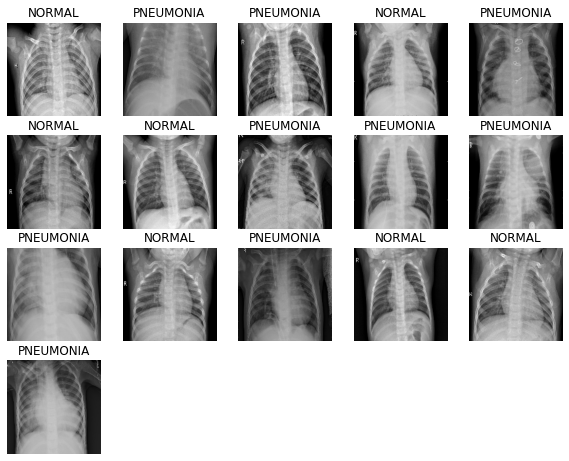

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링
- 가장 대표적인 딥러닝 모델인 CNN을 모델링하고 결과를 만들어 보자
- Convolution block을 만들기
    - conv_block()의 구성은 Convolution을 두번 진행하고,
    - Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결하고,
    - Max Pooling을 하기

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

- Dense Block 구성하기

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

## CNN 모델 만들어보기

- Batch Normalization과 Dropout이라는 두가지 regularization 기법이 동시에 사용되고 있음
- 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다: Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift, variance shift를 억제하는 Batch Normalization과 이를 유발시키는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있음
- 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 있음. 예외적으로 동시에 사용하는 것이 성능향상에 도움을 주는 경우가 실제로 있음. 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있음: Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks
- 이번 실습에서는 두가지를 함께 사용하는 이 모델이 성능향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분임

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

- 데이터를 학습 할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있으므로 데이터 imbalance 처리하기: 'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 라벨에 데이터가 많이 있어서 imbalance 함
- 이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됨: Weight balancing 은 training set의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법임
- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있음
- 아래 코드에서 딥러닝에서 클래스 불균형을 다루는 방법
    - weight_for_0은 'Normal' 이미지에 사용할 weight를 세팅함
    - weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅함
    - 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됨

In [19]:
COUNT_NORMAL, COUNT_PNEUMONIA, TRAIN_IMG_COUNT

(1085, 3100, 4185)

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.68


## 6. 모델 훈련
- 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택함
- 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언함
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용함
- optimizer로 'adam'을 사용함
- 성과 측정 metrics로 'accuracy', 'precision', 'recall'을 사용함

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

- 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어서 모델 fit 진행함

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 23s 86ms/step - loss: 0.3652 - accuracy: 0.8192 - precision: 0.9603 - recall: 0.7886 - val_loss: 0.6623 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 22s 84ms/step - loss: 0.2237 - accuracy: 0.9102 - precision: 0.9705 - recall: 0.9062 - val_loss: 1.1424 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1871 - accuracy: 0.9313 - precision: 0.9762 - recall: 0.9298 - val_loss: 0.4528 - val_accuracy: 0.7702 - val_precision: 0.7650 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 23s 89ms/step - loss: 0.1730 - accuracy: 0.9306 - precision: 0.9772 - recall: 0.9279 - val_loss: 0.7801 - val_accuracy: 0.7490 - val_precision: 0.7488 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 22s 85ms/step - loss: 0.1711 - accuracy: 0

## 7. 결과 확인
- 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 결과를 확인하기

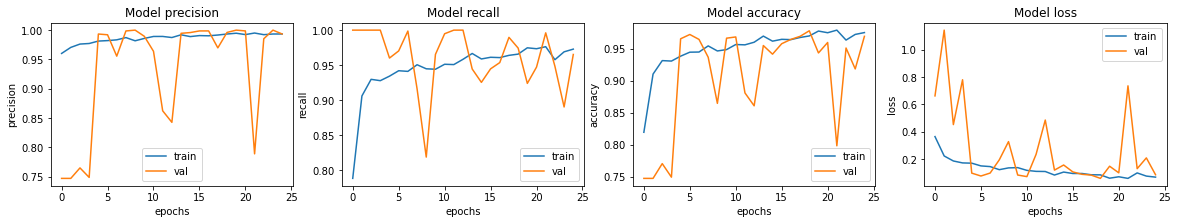

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 테스트 데이터로 모델 평가를 해보기
    - 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력하기

In [24]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 54ms/step - loss: 0.9091 - accuracy: 0.8061 - precision: 0.7717 - recall: 0.9795


# Step 2. 데이터 준비하기
- 의료영상 이미지의 특성상 데이터는 언제나 충분하지 않으므로, 이를 극복할 수 있는 방법을 고민해 보기
- 이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있음
- 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없음
- 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문임
- 의료 영상의 data augmentation은 신중하게 진행 필요: 좌우반전 정도의 augmentation만 도입하기로 함

In [53]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

In [54]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.

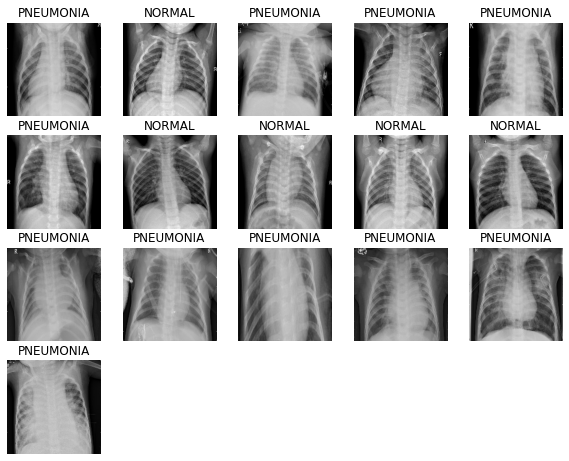

In [55]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링
의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

In [56]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [57]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [58]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        tf.keras.layers.Dropout(0.1),  #dropout 비율을 0.1로 조정
        
        conv_block(64),
        tf.keras.layers.Dropout(0.1),  #dropout 비율을 0.1로 조정
        
        conv_block(128),
        tf.keras.layers.Dropout(0.1),  #dropout 비율을 0.1로 조정
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1),  #dropout 비율을 0.1로 조정
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리
실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?


In [59]:
COUNT_NORMAL, COUNT_PNEUMONIA, TRAIN_IMG_COUNT

(1088, 3097, 4185)

In [62]:
# 데이터 imbalance 처리 생략
weight_for_0 = (1 / TRAIN_IMG_COUNT)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / TRAIN_IMG_COUNT)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 0.50


## Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.


In [63]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [64]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 22s 86ms/step - loss: 0.1931 - accuracy: 0.8367 - precision: 0.9315 - recall: 0.8410 - val_loss: 0.6552 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 86ms/step - loss: 0.1006 - accuracy: 0.9291 - precision: 0.9527 - recall: 0.9515 - val_loss: 1.8611 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 88ms/step - loss: 0.0939 - accuracy: 0.9341 - precision: 0.9550 - recall: 0.9560 - val_loss: 0.5097 - val_accuracy: 0.7846 - val_precision: 0.7771 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 22s 86ms/step - loss: 0.0880 - accuracy: 0.9377 - precision: 0.9562 - recall: 0.9599 - val_loss: 0.1483 - val_accuracy: 0.9519 - val_precision: 0.9933 - val_recall: 0.9425
Epoch 5/25
261/261 [==============================] - 22s 85ms/step - loss: 0.0867 - accuracy: 0

## Step 7. 결과 확인과 시각화
테스트데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

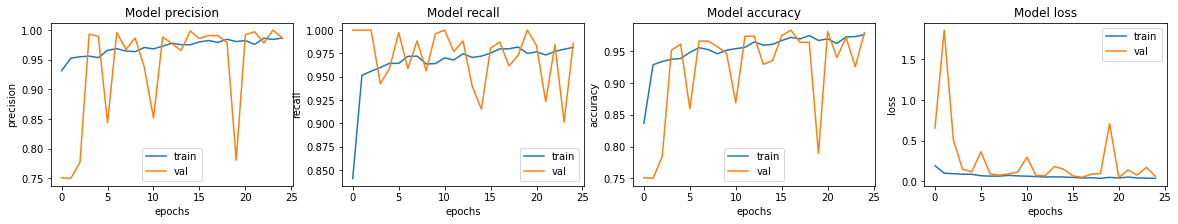

In [65]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [66]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 55ms/step - loss: 1.2841 - accuracy: 0.7516 - precision: 0.7164 - recall: 0.9974


# Step 8. 결과 해석하기

- augmentation: 좌우 대칭만 넣어봄
- con 블록마다 dropout 비율을 0.1로 조정해봄
- 데이터 imbalance 처리 생략

### 학습 조건 결과
~~~
39/39 [==============================] - 2s 54ms/step - loss: 0.9091 - accuracy: 0.8061 - precision: 0.7717 - recall: 0.9795
~~~

### 새로 테스트해본 결과

~~~
39/39 [==============================] - 2s 55ms/step - loss: 1.2841 - accuracy: 0.7516 - precision: 0.7164 - recall: 0.9974
~~~ 


### 기존 결과 vs. 새로운 테스트 결과
- loss: 0.0901 vs. 1.2841
- accuracy: 0.8061 vs. 0.7516
- precision: 0.7717 vs. 0.7162
- recall: 0.9795 vs. 0.9974
    
### 다른 지표는 떨어졌지만, 의료 영상이므로 recall 지수가 오른 것이 더 나은 결과를 가져온다고 해석이 됨